<a href="https://colab.research.google.com/github/PQ-Trung/hello-world-1/blob/master/Transfer_Learning_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[URL](https://www.tensorflow.org/tutorials/images/transfer_learning)



In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', 
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised=True
    )

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteSCLA6Q/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
get_label_name = metadata.features['label'].int2str

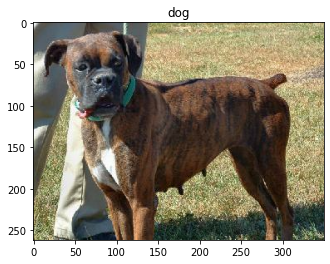

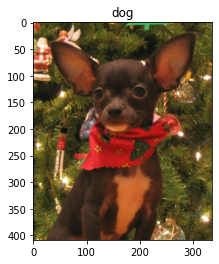

In [7]:
for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

tf.Tensor(1, shape=(), dtype=int64)


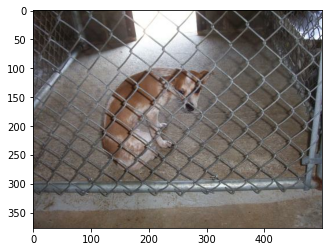

In [39]:
for i in raw_train.shuffle(10).take(1):
    print(i[1])
    plt.imshow(i[0])

In [0]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5)-1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [13]:
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [14]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE, include_top = False,
    weights ='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
# Freeze the conv base
base_model.trainable = False

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [18]:
# Generate prediction from the block of features
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

# Convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)



(32, 1280)
(32, 1)


In [0]:
model = tf.keras.Sequential([base_model, 
                             global_average_layer,
                             prediction_layer])

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
# Number of trainable layers
len(model.trainable_variables)

2

In [23]:
initial_epochs = 10
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 79ms/step - loss: 0.9253 - accuracy: 0.3578


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.93
initial accuracy: 0.36


In [0]:
DESIRED_ACCURACY = 0.9799

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>DESIRED_ACCURACY):
      print("\nReached 97,99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [26]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    callbacks = [callbacks])

Epoch 1/10
582/582 [==============================] - 79s 136ms/step - loss: 0.2456 - accuracy: 0.8818 - val_loss: 0.0917 - val_accuracy: 0.9647
Epoch 2/10
582/582 [==============================] - 79s 136ms/step - loss: 0.0733 - accuracy: 0.9740 - val_loss: 0.0643 - val_accuracy: 0.9759
Epoch 3/10
582/582 [==============================] - 81s 138ms/step - loss: 0.0578 - accuracy: 0.9791 - val_loss: 0.0565 - val_accuracy: 0.9789
Epoch 4/10
582/582 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9812
Reached 97,99% accuracy so cancelling training!
582/582 [==============================] - 75s 129ms/step - loss: 0.0516 - accuracy: 0.9812 - val_loss: 0.0527 - val_accuracy: 0.9807


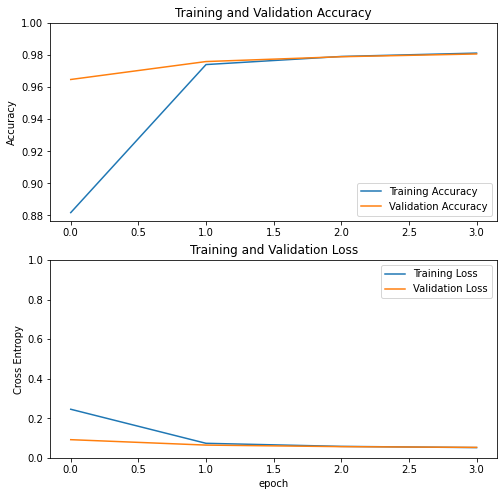

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
# Fine Tuning
# Unfreeze some layers of base_model to training weights

base_model.trainable = True

print("Number of layers in the base model:", len(base_model.layers))

fine_tune = 100
for layer in base_model.layers[:fine_tune]:
    layer.trainable = False

# only train 55 last layers of base_model

Number of layers in the base model: 155


In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [31]:
# Number of trainable layers
len(model.trainable_variables)

58

In [0]:
DESIRED_ACCURACY = 0.99

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>DESIRED_ACCURACY):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [35]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches,
                         callbacks = [callbacks])

Epoch 4/20
582/582 [==============================] - 97s 167ms/step - loss: 0.0939 - accuracy: 0.9624 - val_loss: 0.0551 - val_accuracy: 0.9819
Epoch 5/20
582/582 [==============================] - 85s 146ms/step - loss: 0.0605 - accuracy: 0.9754 - val_loss: 0.0466 - val_accuracy: 0.9845
Epoch 6/20
582/582 [==============================] - 95s 163ms/step - loss: 0.0456 - accuracy: 0.9828 - val_loss: 0.0461 - val_accuracy: 0.9841
Epoch 7/20
582/582 [==============================] - 98s 168ms/step - loss: 0.0382 - accuracy: 0.9860 - val_loss: 0.0496 - val_accuracy: 0.9832
Epoch 8/20
582/582 [==============================] - 98s 168ms/step - loss: 0.0308 - accuracy: 0.9887 - val_loss: 0.0464 - val_accuracy: 0.9841
Epoch 9/20
582/582 [==============================] - 96s 166ms/step - loss: 0.0220 - accuracy: 0.9919 - val_loss: 0.0481 - val_accuracy: 0.9854
Epoch 10/20
582/582 [==============================] - 94s 161ms/step - loss: 0.0192 - accuracy: 0.9934 - val_loss: 0.0495 - val_a

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

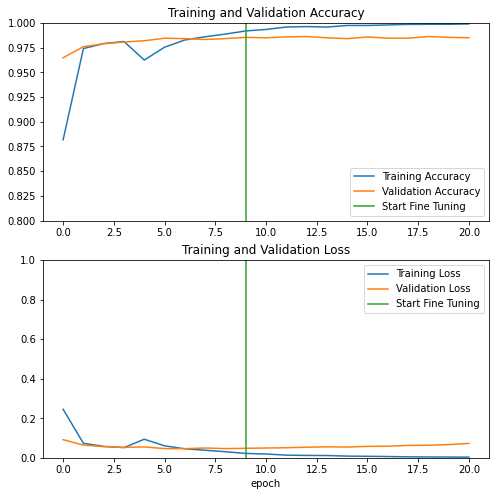

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()